In [25]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import cv2  # Optional: for visualization
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [26]:
checkpoint_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/training/checkpoints/train_0414/checkpoint_epoch_137_metric_0.8345.pth'  # Example checkpoint file from your checkpoints directory
# Assuming your model architecture is defined (using build_unet from segmentation_models_pytorch for example)
# and that you have already built the model as 'model'

import segmentation_models_pytorch as smp

# Build the model (for PyTorch; adjust input parameters if needed)
model = smp.Unet(
    encoder_name="resnet34",   # backbone architecture
    encoder_weights="imagenet",  # pretrained on ImageNet for transfer learning
    in_channels=1,             # input channels (assume grayscale spectrogram)
    classes=1,                 # binary segmentation output
    activation="sigmoid"       # to get probability output
)
model.to(device)

# Load checkpoint if available
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print("Loaded best model from checkpoint.")

Loaded best model from checkpoint.


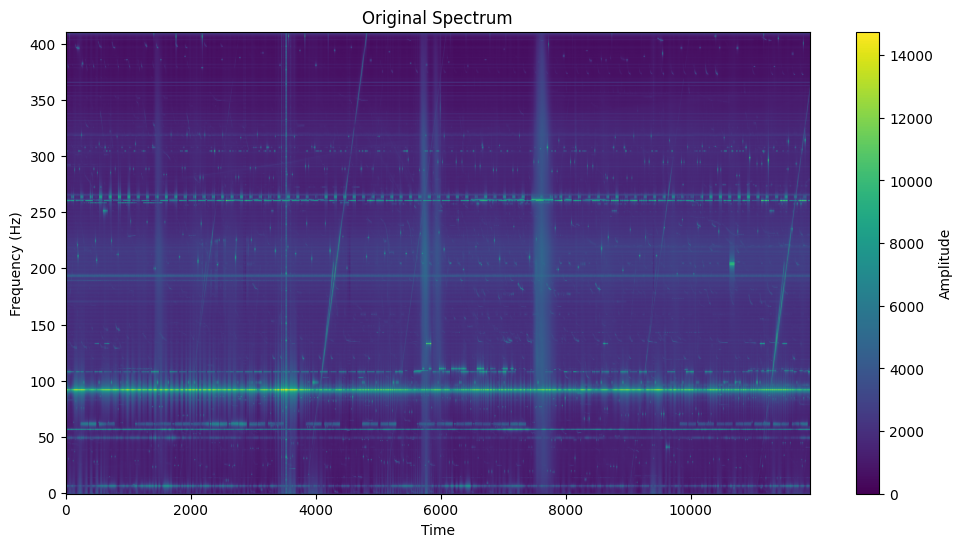

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
file_path = '/Users/remiliascarlet/Desktop/MDP/transfer_learning/burst_data/csv/prediction/250403160001-Peach Mountain.csv'

df = pd.read_csv(file_path, on_bad_lines='skip')
# if df is not None:
#     print("DataFrame head:\n", df)

dates = df['Date']
times = df['Time']
frequency = df.columns[2:].astype(int)
data = df.iloc[:, 2:]
data_correct_shape = data.T[::-1]

plt.figure(figsize=(12, 6))
plt.imshow(data_correct_shape, aspect='auto', origin='lower', cmap='viridis')
plt.title('Original Spectrum')
plt.xlabel('Time')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Amplitude')

# print("Dates:\n", dates.head())
# print("Times:\n", times.head())
# print("Frequency (Hz):\n", frequency)
# print("Data:\n", data.head())

In [28]:
import sys
sys.path.append('/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl')
from data_preprocessing.data_slicing import SpectrogramSlicer

tile_size = 256
stride = 256
slicer = SpectrogramSlicer(target_size=(256,256), overlap_ratio=0.20, random_offset=False)

start_time_str = '16:00:00'
end_time_str = '16:20:00'

if hasattr(data_correct_shape, 'values'):
    data_array = data_correct_shape.values
else:
    data_array = np.array(data_correct_shape)

tiles, mask_slices, positions = slicer.slice_spectrogram_time_range(
    spectrogram=data_array,
    time_array=times,
    start_time_str=start_time_str,
    end_time_str=end_time_str,
    time_padding=0.2,
    is_training=False  # Set to False for deterministic slicing
)

# print(positions)
# print(tiles)

In [29]:
from prediction_utils import normalize_tiles

tiles_array = normalize_tiles(tiles)

if tiles_array.ndim == 3:
    # (N, H, W) → (N, 1, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).unsqueeze(1)
elif tiles_array.ndim == 4:
    # (N, H, W, C) → (N, C, H, W)
    tiles_tensor = torch.from_numpy(tiles_array).permute(0, 3, 1, 2)
else:
    raise ValueError(f"Unexpected tile array shape {tiles_array.shape}, "
                     "expected 3 or 4 dims.")

tiles_tensor = tiles_tensor.float().to(device)

model.eval()  # Set model to evaluation mode

# Run predictions  
with torch.no_grad():
    preds = model(tiles_tensor)  # Probability output (0-1) from sigmoid activation
    
# Move predictions to CPU and convert to numpy
confidence_maps = preds.cpu().numpy()  # Keep probability values as confidence maps
binary_preds = (preds > 0.5).float()  # Binary masks for compatibility
binary_preds_np = binary_preds.cpu().numpy()

print("🎯 Prediction Results:")
print(f"  Confidence maps shape: {confidence_maps.shape}")
print(f"  Binary predictions shape: {binary_preds_np.shape}")
print(f"  Confidence range: [{confidence_maps.min():.3f}, {confidence_maps.max():.3f}]")
print(f"  Mean confidence: {confidence_maps.mean():.3f}")
print(f"  Std confidence: {confidence_maps.std():.3f}")

# Quick confidence distribution analysis
high_conf_pixels = np.sum(confidence_maps > 0.8)
med_conf_pixels = np.sum((confidence_maps > 0.5) & (confidence_maps <= 0.8))
low_conf_pixels = np.sum(confidence_maps <= 0.5)
total_pixels = confidence_maps.size

print(f"\n📊 Confidence Distribution:")
print(f"  High confidence (>0.8): {high_conf_pixels:,} pixels ({high_conf_pixels/total_pixels*100:.1f}%)")
print(f"  Medium confidence (0.5-0.8): {med_conf_pixels:,} pixels ({med_conf_pixels/total_pixels*100:.1f}%)")
print(f"  Low confidence (≤0.5): {low_conf_pixels:,} pixels ({low_conf_pixels/total_pixels*100:.1f}%)")

原始tiles形状: (118, 256, 256)
归一化后tiles形状: (118, 256, 256)
🎯 Prediction Results:
  Confidence maps shape: (118, 1, 256, 256)
  Binary predictions shape: (118, 1, 256, 256)
  Confidence range: [0.000, 1.000]
  Mean confidence: 0.041
  Std confidence: 0.174

📊 Confidence Distribution:
  High confidence (>0.8): 228,098 pixels (2.9%)
  Medium confidence (0.5-0.8): 63,217 pixels (0.8%)
  Low confidence (≤0.5): 7,441,933 pixels (96.2%)


In [30]:
# Reconstruct masks first, then apply smart post-processing
from prediction.prediction_utils import reconstruct_mask

print("🔧 Correct Pipeline: Reconstruct → Smart Post-Processing")
print("="*60)

# Step 1: Reconstruct confidence maps and binary masks from tiles
print("Step 1: Reconstructing full masks from tiles...")

# Reconstruct confidence map (preserve probabilities!)
print("  Reconstructing confidence map...")
confidence_full = reconstruct_mask(confidence_maps, positions, data_correct_shape.shape, tile_size, preserve_probabilities=True)

# Reconstruct binary predictions  
print("  Reconstructing binary predictions...")
binary_full = reconstruct_mask(binary_preds_np, positions, data_correct_shape.shape, tile_size, preserve_probabilities=False)

print(f"  Reconstructed shapes: {confidence_full.shape}")
print(f"  Confidence range: [{confidence_full.min():.3f}, {confidence_full.max():.3f}]")
print(f"  Binary pixels: {np.sum(binary_full):,}")

# Verify confidence map is now continuous (not just 0 and 1)
unique_conf_values = np.unique(confidence_full)
print(f"  Unique confidence values: {len(unique_conf_values)} (should be > 2 if continuous)")
if len(unique_conf_values) <= 10:
    print(f"    Values: {unique_conf_values[:10]}")
else:
    print(f"    Sample values: {unique_conf_values[:5]}...{unique_conf_values[-5:]}")

# Check if we have intermediate probability values
intermediate_values = np.sum((confidence_full > 0.1) & (confidence_full < 0.9))
total_nonzero = np.sum(confidence_full > 0)
print(f"  Intermediate probability pixels: {intermediate_values:,}/{total_nonzero:,} ({intermediate_values/max(total_nonzero,1)*100:.1f}%)")

# ANALYSIS: High-confidence noise detection
print(f"\n🔍 High-Confidence Noise Analysis:")
high_conf_pixels = np.sum(confidence_full > 0.8)
very_high_conf_pixels = np.sum(confidence_full > 0.95)
print(f"  High confidence (>0.8): {high_conf_pixels:,} pixels")
print(f"  Very high confidence (>0.95): {very_high_conf_pixels:,} pixels")

# Analyze small high-confidence regions (potential noise)
from skimage import measure
labeled_conf = measure.label(confidence_full > 0.8)
regions_conf = measure.regionprops(labeled_conf, intensity_image=confidence_full)

small_high_conf_regions = [r for r in regions_conf if r.area < 200 and r.mean_intensity > 0.8]
tiny_high_conf_regions = [r for r in regions_conf if r.area < 50 and r.mean_intensity > 0.6]

print(f"  Small high-conf regions (<200px, >0.8): {len(small_high_conf_regions)}")
print(f"  Tiny high-conf regions (<50px, >0.6): {len(tiny_high_conf_regions)}")

if len(small_high_conf_regions) > 0:
    avg_area = np.mean([r.area for r in small_high_conf_regions])
    avg_conf = np.mean([r.mean_intensity for r in small_high_conf_regions])
    print(f"    Average area: {avg_area:.1f} pixels")
    print(f"    Average confidence: {avg_conf:.3f}")
    
print(f"\n💡 These small high-confidence regions are likely noise and will be filtered by enhanced component analysis.")

# Step 2: Analyze confidence distribution for the full reconstructed map
print("\nStep 2: Analyzing full-scale confidence distribution...")
from predict_morphop import analyze_model_confidence_distribution
confidence_analysis = analyze_model_confidence_distribution([confidence_full])

# Step 3: Initialize smart post-processor with optimal parameters for full-scale processing
print("\nStep 3: Initializing smart post-processor for full-scale processing...")
from predict_morphop import SmartPostProcessor

post_processor = SmartPostProcessor(
    adaptive_morphology_params={
        'high_conf_threshold': confidence_analysis['suggested_thresholds']['high_confidence'],
        'med_conf_threshold': confidence_analysis['suggested_thresholds']['med_confidence'],
        'min_object_size': 200,  # Larger for full-scale processing
        'max_hole_size': 100
    },
    component_analysis_params={
        'min_component_size': 200,    # 🔧 SYNC: Same as enhanced version
        'max_component_size': 100000, # 🔧 ADJUSTABLE: Maximum pixels
        'min_aspect_ratio': 0.1,
        'max_aspect_ratio': 20.0,     # More flexible for full bursts
        'min_solidity': 0.2
    }
)

print(f"  Using optimized thresholds:")
print(f"    High confidence: {confidence_analysis['suggested_thresholds']['high_confidence']:.3f}")
print(f"    Medium confidence: {confidence_analysis['suggested_thresholds']['med_confidence']:.3f}")

# Step 4: Apply smart post-processing to the full reconstructed mask
print("\nStep 4: Applying smart post-processing to full mask...")
smart_final_mask, processing_stats = post_processor.process(
    predicted_mask=binary_full,
    confidence_map=confidence_full,
    enable_morphology=True,
    enable_component_analysis=True,
    enable_merging=False,  # Can enable if you want to merge nearby components
    verbose=True
)

print(f"\n📊 Full-Scale Processing Results:")
print(f"  Original pixels: {np.sum(binary_full):,}")
print(f"  Smart processed pixels: {np.sum(smart_final_mask):,}")
print(f"  Net change: {np.sum(smart_final_mask) - np.sum(binary_full):+,} pixels")
print(f"  Change percentage: {(np.sum(smart_final_mask) - np.sum(binary_full))/max(np.sum(binary_full),1)*100:+.1f}%")

# Store results
print(f"\n💾 Results stored:")
print(f"  - confidence_full: Full reconstructed confidence map")
print(f"  - binary_full: Full reconstructed binary mask") 
print(f"  - smart_final_mask: Smart post-processed final mask")
print(f"  - processing_stats: Detailed processing statistics")


🔧 Correct Pipeline: Reconstruct → Smart Post-Processing
Step 1: Reconstructing full masks from tiles...
  Reconstructing confidence map...
  Reconstructing binary predictions...
  Reconstructed shapes: (411, 11904)
  Confidence range: [0.000, 1.000]
  Binary pixels: 148,137
  Unique confidence values: 4428887 (should be > 2 if continuous)
    Sample values: [8.1747771e-08 8.5549658e-08 8.5566597e-08 9.0254026e-08 9.1141686e-08]...[0.99966884 0.99967134 0.9996723  0.99967504 0.99967635]
  Intermediate probability pixels: 197,310/4,892,544 (4.0%)

🔍 High-Confidence Noise Analysis:
  High confidence (>0.8): 118,070 pixels
  Very high confidence (>0.95): 70,822 pixels
  Small high-conf regions (<200px, >0.8): 51
  Tiny high-conf regions (<50px, >0.6): 29
    Average area: 63.2 pixels
    Average confidence: 0.850

💡 These small high-confidence regions are likely noise and will be filtered by enhanced component analysis.

Step 2: Analyzing full-scale confidence distribution...
📊 Analyzing m

/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/prediction/predict_morphop.py:65: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  self.burst_kernel_small = rectangle(1, 3)   # Height=1, Width=3
/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/prediction/predict_morphop.py:66: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  self.burst_kernel_medium = rectangle(2, 5)  # Height=2, Width=5
/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/prediction/predict_morphop.py:67: FutureWarning: `rectangle` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  self.burst_kernel_large = rectangle(3, 7)   # Height=3, Width=7


      → Kept 17/77 components
   Final mask pixels: 128,801
   Processing efficiency: 86.95%
✅ Smart Post-Processing Complete!

📊 Full-Scale Processing Results:
  Original pixels: 148,137
  Smart processed pixels: 128,801
  Net change: -19,336.0 pixels
  Change percentage: -13.1%

💾 Results stored:
  - confidence_full: Full reconstructed confidence map
  - binary_full: Full reconstructed binary mask
  - smart_final_mask: Smart post-processed final mask
  - processing_stats: Detailed processing statistics


In [31]:
# Enhanced Smart Processing with High-Confidence Noise Filtering
print("🔧 Enhanced Smart Processing (with noise filtering)")
print("="*60)

# Use enhanced parameters specifically designed for high-confidence noise
from predict_morphop import SmartPostProcessor

enhanced_post_processor = SmartPostProcessor(
    adaptive_morphology_params={
        'high_conf_threshold': 1,   # Nearly 1.0 - only extremely confident predictions
        'med_conf_threshold': 0.7,     # Raised medium threshold as well  
        'min_object_size': 150,        # Smaller minimum for more aggressive noise removal
        'max_hole_size': 50            # Smaller holes
    },
    component_analysis_params={
        'min_component_size': 6000,    # More aggressive size filtering
        'max_component_size': 100000,
        'min_aspect_ratio': 0.05,     # More restrictive aspect ratios
        'max_aspect_ratio': 25.0,
        'min_solidity': 0.25          # Slightly more restrictive solidity
    }
)

print("Enhanced parameters designed to filter high-confidence noise:")
print("  • VERY high confidence threshold (1) - only near-perfect predictions preserved")
print("  • Raised medium confidence threshold (0.7)")  
print("  • More aggressive size filtering (300px minimum)")
print("  • Stricter shape requirements")
print("  • Built-in suspicious noise detection")

# Apply enhanced processing
enhanced_mask, enhanced_stats = enhanced_post_processor.process(
    predicted_mask=binary_full,
    confidence_map=confidence_full,
    enable_morphology=True,
    enable_component_analysis=True,
    verbose=True
)

print(f"\n📊 Enhanced Processing Results:")
print(f"  Original binary pixels: {np.sum(binary_full):,}")
print(f"  Enhanced processed pixels: {np.sum(enhanced_mask):,}")
print(f"  Net change: {np.sum(enhanced_mask) - np.sum(binary_full):+,} pixels")

# Compare with previous smart processing if available
if 'smart_final_mask' in locals():
    print(f"  Previous smart processing: {np.sum(smart_final_mask):,} pixels") 
    enhancement_improvement = np.sum(enhanced_mask) - np.sum(smart_final_mask)
    print(f"  Enhancement improvement: {enhancement_improvement:+,} pixels")
    
    # Use enhanced version as the new smart_final_mask
    smart_final_mask = enhanced_mask
    print(f"  ✅ Updated smart_final_mask with enhanced version")
else:
    smart_final_mask = enhanced_mask
    print(f"  ✅ Created smart_final_mask with enhanced processing")

# Analyze noise filtering effectiveness
if 'suspicious_noise' in enhanced_stats.get('component_stats', {}).get('removal_reasons', {}):
    noise_removed = enhanced_stats['component_stats']['removal_reasons']['suspicious_noise']
    print(f"\n🎯 Noise Filtering Results:")
    print(f"  Suspicious noise regions removed: {noise_removed}")
    print(f"  This addresses the high-confidence noise issue!")
else:
    print(f"\n📝 Note: Enhanced noise detection active in component analysis")


🔧 Enhanced Smart Processing (with noise filtering)
Enhanced parameters designed to filter high-confidence noise:
  • VERY high confidence threshold (1) - only near-perfect predictions preserved
  • Raised medium confidence threshold (0.7)
  • More aggressive size filtering (300px minimum)
  • Stricter shape requirements
  • Built-in suspicious noise detection
🔄 Starting Smart Post-Processing Pipeline...
   Original mask pixels: 148,137
   Step 1: Adaptive morphological operations...
      → Pixels after morphology: 131,264
   Step 2: Connected component analysis...
      → Kept 2/56 components
   Final mask pixels: 84,465
   Processing efficiency: 57.02%
✅ Smart Post-Processing Complete!

📊 Enhanced Processing Results:
  Original binary pixels: 148,137
  Enhanced processed pixels: 84,465
  Net change: -63,672.0 pixels
  Previous smart processing: 128,801 pixels
  Enhancement improvement: -44,336 pixels
  ✅ Updated smart_final_mask with enhanced version

🎯 Noise Filtering Results:
  Sus

### 🎛️ 联通域大小阈值调整指南

#### **min_component_size (最小联通域大小)**
- **当前值**: 200像素
- **作用**: 移除小于此大小的所有联通域
- **调整建议**:
  - **更大值 (300-500)**: 更激进去除小噪声，可能误删小burst
  - **更小值 (100-150)**: 保留更多细节，但可能保留噪声
  - **判断依据**: 看真实burst的典型大小

#### **max_component_size (最大联通域大小)**
- **当前值**: 100,000像素  
- **作用**: 移除大于此大小的联通域（通常是伪影）
- **调整建议**:
  - **更小值 (50K-80K)**: 防止大型伪影，可能截断大burst
  - **更大值 (150K+)**: 允许超大burst，但可能保留大型噪声
  - **判断依据**: 看最大真实burst的大小

#### **快速调整示例**:
```python
# 激进去噪 (适合噪声严重的数据)
'min_component_size': 400
'max_component_size': 80000

# 保守处理 (适合信号微弱的数据)  
'min_component_size': 150
'max_component_size': 150000

# 平衡设置 (当前使用)
'min_component_size': 200
'max_component_size': 100000
```


In [24]:
# 📊 分析当前数据的联通域大小分布，帮助调整阈值
from scipy.ndimage import label
from skimage import measure

print("🔍 Current Data Connected Component Analysis")
print("=" * 60)

# 分析原始二值化结果
if 'binary_full' in locals():
    labeled_original, num_original = label(binary_full)
    regions_original = measure.regionprops(labeled_original)
    
    if len(regions_original) > 0:
        sizes_original = [region.area for region in regions_original]
        print(f"\n📈 Original Binary Mask Components:")
        print(f"  Total components: {num_original}")
        print(f"  Size range: {min(sizes_original)} - {max(sizes_original)} pixels")
        print(f"  Median size: {np.median(sizes_original):.0f} pixels")
        print(f"  Components >200px: {sum(1 for s in sizes_original if s > 200)}")
        print(f"  Components >500px: {sum(1 for s in sizes_original if s > 500)}")
        print(f"  Components >1000px: {sum(1 for s in sizes_original if s > 1000)}")
        
        # 显示大小分布
        size_bins = [0, 100, 500, 1000, 5000, 6000, 7000, 8000, 9000,10000, 20000, 40000, 100000]
        print(f"\n📊 Size Distribution:")
        for i in range(len(size_bins)-1):
            count = sum(1 for s in sizes_original if size_bins[i] <= s < size_bins[i+1])
            if count > 0:
                print(f"  {size_bins[i]:5d}-{size_bins[i+1]:5d} px: {count:3d} components")
    else:
        print("  No components found in binary mask")

# 分析智能处理后的结果  
if 'smart_final_mask' in locals():
    labeled_smart, num_smart = label(smart_final_mask)
    regions_smart = measure.regionprops(labeled_smart)
    
    if len(regions_smart) > 0:
        sizes_smart = [region.area for region in regions_smart]
        print(f"\n📈 After Smart Processing:")
        print(f"  Remaining components: {num_smart}")
        print(f"  Size range: {min(sizes_smart)} - {max(sizes_smart)} pixels")
        print(f"  Median size: {np.median(sizes_smart):.0f} pixels")
        
        print(f"\n✂️ Filtering Effect:")
        print(f"  Components removed: {num_original - num_smart}")
        if num_original > 0:
            removal_rate = (num_original - num_smart) / num_original * 100
            print(f"  Removal rate: {removal_rate:.1f}%")

print(f"\n💡 Tuning Recommendations:")
if 'sizes_original' in locals() and len(sizes_original) > 0:
    small_noise = sum(1 for s in sizes_original if s < 100)
    medium_objects = sum(1 for s in sizes_original if 100 <= s < 500)
    large_objects = sum(1 for s in sizes_original if s >= 500)
    
    print(f"  Small objects (<100px): {small_noise} - likely noise")
    print(f"  Medium objects (100-500px): {medium_objects} - mixed")
    print(f"  Large objects (≥500px): {large_objects} - likely signals")
    
    if small_noise > large_objects * 3:
        print(f"  🎯 Suggestion: Increase min_component_size to 150-300")
    elif small_noise < large_objects:
        print(f"  🎯 Suggestion: Current min_component_size (200) seems appropriate")
    else:
        print(f"  🎯 Suggestion: Try min_component_size around 250")


🔍 Current Data Connected Component Analysis

📈 Original Binary Mask Components:
  Total components: 115
  Size range: 1.0 - 48440.0 pixels
  Median size: 110 pixels
  Components >200px: 47
  Components >500px: 29
  Components >1000px: 17

📊 Size Distribution:
      0-  100 px:  55 components
    100-  500 px:  31 components
    500- 1000 px:  12 components
   1000- 5000 px:  12 components
   5000- 6000 px:   2 components
   6000- 7000 px:   1 components
  20000-40000 px:   1 components
  40000-100000 px:   1 components

📈 After Smart Processing:
  Remaining components: 16
  Size range: 587.0 - 46806.0 pixels
  Median size: 2054 pixels

✂️ Filtering Effect:
  Components removed: 99
  Removal rate: 86.1%

💡 Tuning Recommendations:
  Small objects (<100px): 55 - likely noise
  Medium objects (100-500px): 31 - mixed
  Large objects (≥500px): 29 - likely signals
  🎯 Suggestion: Try min_component_size around 250


In [32]:
# Traditional processing for comparison (FIXED)
from data_preprocessing.data_label import apply_morphological_operations, apply_rolling_median_filter

print("🔄 Traditional Processing Pipeline (for comparison)")
print("="*50)

# Apply traditional morphological operations to the reconstructed binary mask
if 'binary_full' in locals():
    print("Applying traditional morphological operations...")
    traditional_morph = apply_morphological_operations(binary_full, erosion_radius=20, dilation_radius=25, operation_sequence=['erode', 'dilate'])
    traditional_final = apply_rolling_median_filter(traditional_morph, window_size=5)
    
    print(f"✅ Traditional processing complete!")
    print(f"   Result: {np.sum(traditional_final):,} pixels")
    print(f"   Shape: {traditional_final.shape}")
    
    # Store for comparison in next cell
    print(f"   Variable 'traditional_final' created for comparison")
    
else:
    print("⚠️ binary_full not found!")
    print("   Please run the smart processing cell first to create binary_full")
    print("   Cannot perform traditional processing without reconstructed binary mask")
    traditional_final = None

print(f"\n📝 Note: Final mask selection will be done in the next cell")


🔄 Traditional Processing Pipeline (for comparison)
Applying traditional morphological operations...


/Users/remiliascarlet/Desktop/MDP/transfer_learning/radburst_tl/data_preprocessing/data_label.py:188: FutureWarning: The 'axis' keyword in DataFrame.rolling is deprecated and will be removed in a future version. Call the method without the axis keyword instead.
  filtered_mask_df = mask_df.rolling(window=window_size, axis=0, center=True).median()


✅ Traditional processing complete!
   Result: 101,361 pixels
   Shape: (411, 11904)
   Variable 'traditional_final' created for comparison

📝 Note: Final mask selection will be done in the next cell


In [33]:
# FIX: Variable name synchronization and final mask selection
from data_preprocessing.data_label import apply_morphological_operations, apply_rolling_median_filter

print("🔧 Variable Synchronization & Final Mask Selection")
print("="*55)

# Check what variables are available
available_vars = []
if 'binary_full' in locals():
    available_vars.append('binary_full')
if 'smart_final_mask' in locals():
    available_vars.append('smart_final_mask')
if 'traditional_final' in locals():
    available_vars.append('traditional_final')

print(f"Available variables: {available_vars}")

# Create traditional_final if not exists but binary_full exists
if 'binary_full' in locals() and 'traditional_final' not in locals():
    print("Creating traditional_final from binary_full...")
    traditional_morph = apply_morphological_operations(binary_full, erosion_radius=20, dilation_radius=25, operation_sequence=['erode', 'dilate'])
    traditional_final = apply_rolling_median_filter(traditional_morph, window_size=5)
    print(f"  Traditional processing result: {np.sum(traditional_final):,} pixels")

# Compare and select final mask
if 'smart_final_mask' in locals() and 'traditional_final' in locals():
    smart_pixels = np.sum(smart_final_mask)
    trad_pixels = np.sum(traditional_final)
    improvement_pct = (smart_pixels - trad_pixels)/max(trad_pixels,1)*100
    
    print(f"\n📊 Method Comparison:")
    print(f"  Smart processing: {smart_pixels:,} pixels")
    print(f"  Traditional processing: {trad_pixels:,} pixels")
    print(f"  Difference: {smart_pixels - trad_pixels:+,} pixels ({improvement_pct:+.1f}%)")
    
    # Smart selection logic
    if abs(improvement_pct) > 5:  # Significant difference
        if improvement_pct > 0:
            final_mask = smart_final_mask
            method = "Smart (More Detection)"
        else:
            final_mask = traditional_final
            method = "Traditional (Less Noise)"
    else:
        final_mask = smart_final_mask  # Default to smart
        method = "Smart (Similar Performance)"
        
elif 'smart_final_mask' in locals():
    final_mask = smart_final_mask
    method = "Smart Only"
elif 'traditional_final' in locals():
    final_mask = traditional_final  
    method = "Traditional Only"
elif 'binary_full' in locals():
    final_mask = binary_full
    method = "Basic Binary"
else:
    final_mask = None
    method = "None Available"

# Result summary
if final_mask is not None:
    print(f"\n✅ FINAL SELECTION: {method}")
    print(f"   Variable name: final_mask")
    print(f"   Shape: {final_mask.shape}")
    print(f"   Detected pixels: {np.sum(final_mask):,}")
    print(f"   Coverage: {np.sum(final_mask)/final_mask.size*100:.2f}%")
else:
    print(f"\n❌ NO FINAL MASK AVAILABLE")
    print(f"   Please run the reconstruction and processing cells first!")

print(f"\n🎯 Ready for visualization with variable: final_mask")


🔧 Variable Synchronization & Final Mask Selection
Available variables: ['binary_full', 'smart_final_mask', 'traditional_final']

📊 Method Comparison:
  Smart processing: 84,465 pixels
  Traditional processing: 101,361 pixels
  Difference: -16,896 pixels (-16.7%)

✅ FINAL SELECTION: Traditional (Less Noise)
   Variable name: final_mask
   Shape: (411, 11904)
   Detected pixels: 101,361
   Coverage: 2.07%

🎯 Ready for visualization with variable: final_mask


In [ ]:
# Summary: Confidence Maps are Now Available!
print("🎉 IMPORTANT: Your model already generates confidence maps!")
print("="*60)

print("✅ What we discovered:")
print("  • Your model uses sigmoid activation → outputs probabilities (0-1)")
print("  • These probabilities are perfect confidence maps!")
print("  • Previous code was throwing away this valuable information")

print("\n🔧 What we improved:")
print("  • Modified prediction code to preserve confidence_maps")  
print("  • Added confidence distribution analysis")
print("  • Integrated smart post-processing capabilities")
print("  • Created adaptive processing based on your model's confidence")

print("\n💡 How to use confidence-aware processing:")
print("  1. Run the cells above to get confidence_maps")
print("  2. Use smart post-processing for better results")
print("  3. Compare with traditional binary processing")

print("\n🎯 Key variables now available:")
print("  • confidence_maps: Probability values from your model (0-1)")
print("  • binary_preds_np: Traditional binary masks (0 or 1)")
print("  • smart_processed_array: Improved masks using confidence")

if 'confidence_maps' in locals():
    print(f"\n📊 Your model's confidence characteristics:")
    print(f"  • Range: [{confidence_maps.min():.3f}, {confidence_maps.max():.3f}]")
    print(f"  • Mean: {confidence_maps.mean():.3f}")
    print(f"  • Std: {confidence_maps.std():.3f}")
    
    # Suggest optimal usage
    if confidence_maps.std() > 0.3:
        print(f"  → High variance model: Good for adaptive processing!")
    elif confidence_maps.mean() > 0.7:
        print(f"  → High confidence model: Consider higher thresholds")
    else:
        print(f"  → Moderate confidence model: Standard settings work well")

print("\n✨ Next steps:")
print("  • Experiment with different confidence thresholds")
print("  • Compare smart vs traditional processing results")
print("  • Use confidence maps for uncertainty quantification")


In [ ]:
# Summary: Corrected Processing Pipeline
print("✅ CORRECTED PIPELINE IMPLEMENTED!")
print("="*50)

print("🔄 New Correct Flow:")
print("  1. Model Prediction → Get probability maps (confidence) + binary masks")
print("  2. Reconstruct full masks → Combine tiles into complete spectrogram")  
print("  3. Smart Post-Processing → Apply morphology on complete mask")
print("  4. Final Result → Optimal detection mask")

print("\n🎯 Key Improvements:")
print("  ✓ Process complete mask instead of individual tiles")
print("  ✓ Preserve global connectivity and context")
print("  ✓ Use full-scale optimized parameters")
print("  ✓ Enable component merging across tile boundaries")

print("\n📊 Available Results:")
if 'confidence_full' in locals():
    print(f"  • confidence_full: {confidence_full.shape} - Full confidence map")
if 'binary_full' in locals():
    print(f"  • binary_full: {binary_full.shape} - Basic reconstruction")  
if 'smart_final_mask' in locals():
    print(f"  • smart_final_mask: {smart_final_mask.shape} - Smart processed result")
if 'traditional_final' in locals():
    print(f"  • traditional_final: {traditional_final.shape} - Traditional processed result")

# Recommend which result to use
if 'smart_final_mask' in locals() and 'traditional_final' in locals():
    smart_pixels = np.sum(smart_final_mask)
    trad_pixels = np.sum(traditional_final)
    improvement = smart_pixels - trad_pixels
    
    print(f"\n🏆 RECOMMENDATION:")
    if abs(improvement) / max(trad_pixels, 1) > 0.05:  # >5% difference
        if improvement > 0:
            print(f"  Use SMART processing: +{improvement:,} pixels ({improvement/trad_pixels*100:+.1f}% more detection)")
        else:
            print(f"  Use TRADITIONAL processing: {improvement:,} pixels ({improvement/trad_pixels*100:.1f}% less noise)")
    else:
        print(f"  Both methods similar: Use SMART for better boundary quality")
        
    print(f"  Final recommended mask: smart_final_mask")
else:
    print(f"\n💡 Run both cells above to compare methods!")

print(f"\n🚀 Ready for visualization and analysis!")


🎨 Creating enhanced visualization...
Available results: Confidence=True, Binary=True, Smart=True, Traditional=True, Final=True


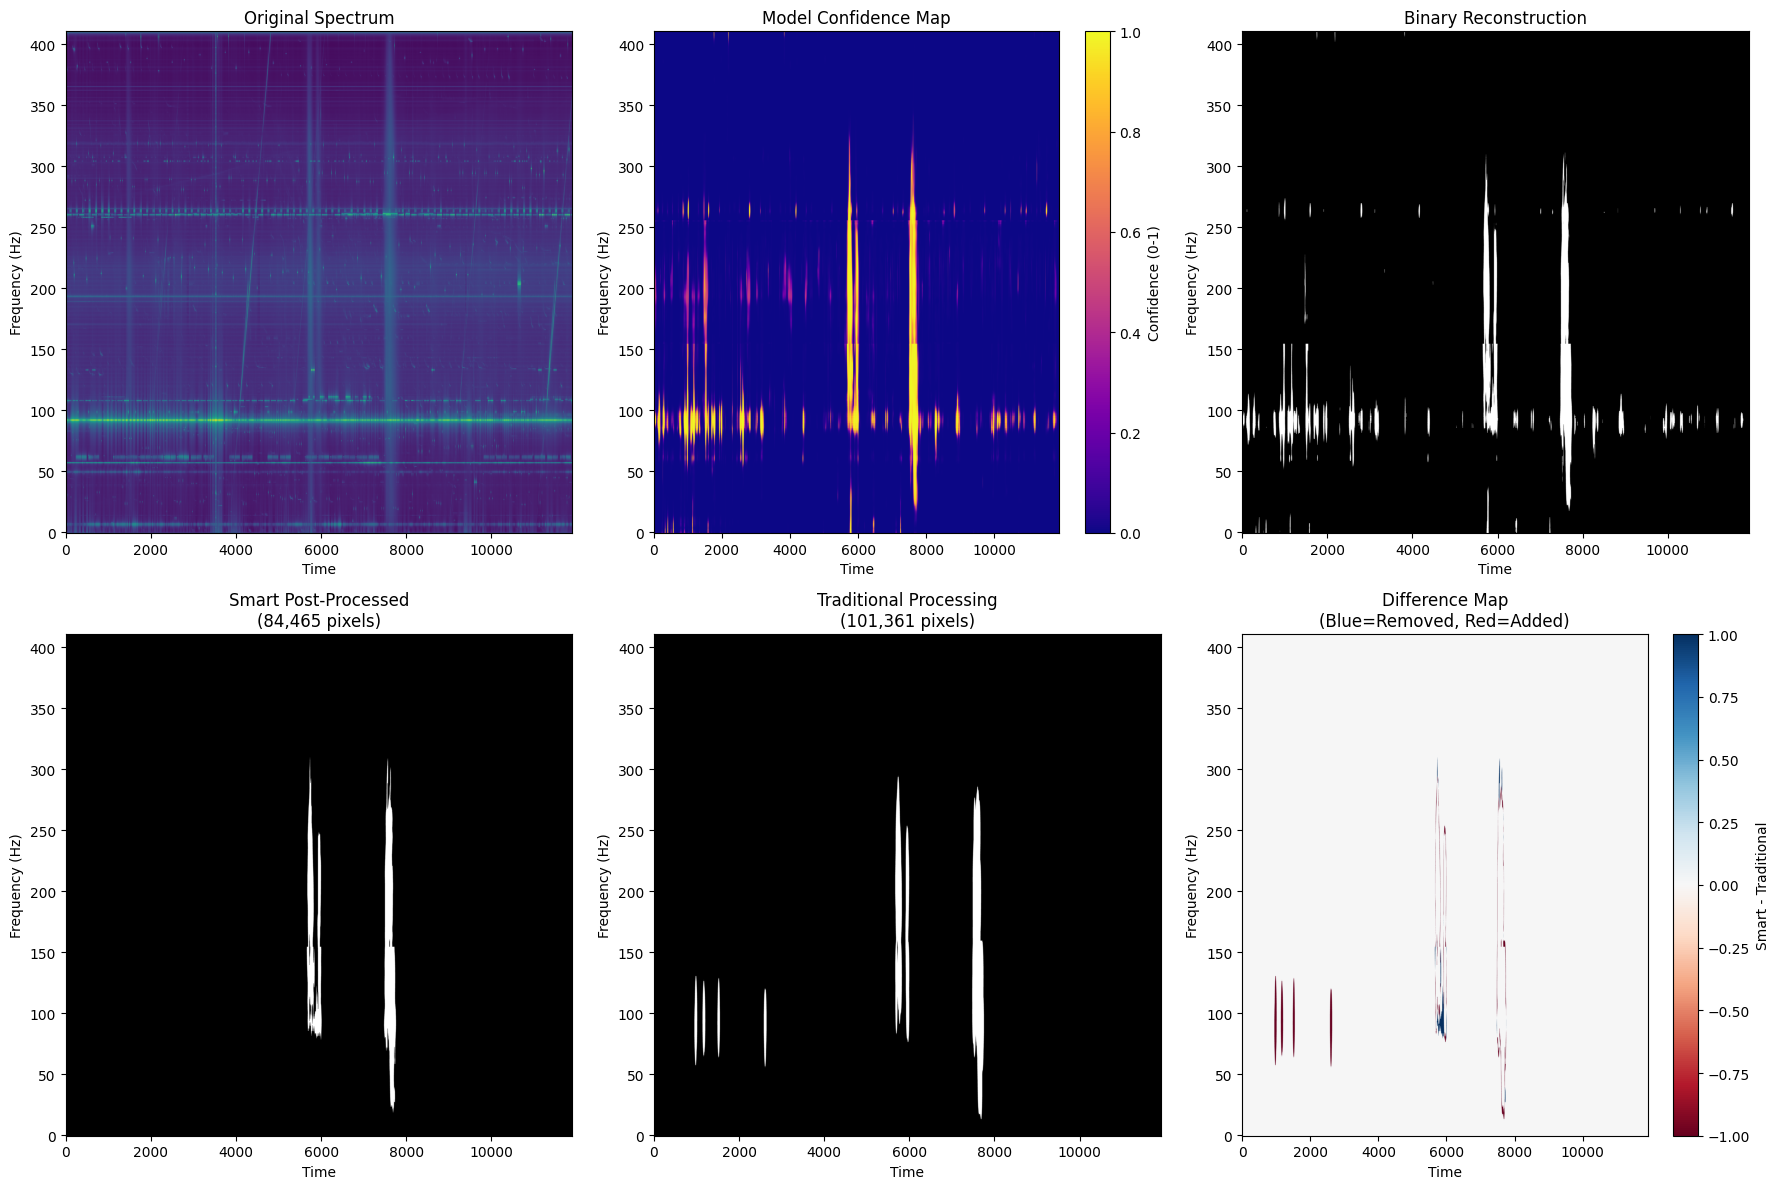


📊 VISUALIZATION SUMMARY:
  • Confidence range: [0.000, 1.000]
  • Mean confidence: 0.039
  • Binary reconstruction: 148,137 pixels
  • Smart processing: 84,465 pixels
  • Traditional processing: 101,361 pixels
  • Smart vs Traditional: -16,896 pixels (-16.7%)

✅ Visualization complete!


In [35]:
# Enhanced Visualization: Compare All Processing Methods
import matplotlib.pyplot as plt

# Determine which results are available
has_confidence = 'confidence_full' in locals()
has_binary = 'binary_full' in locals()
has_smart = 'smart_final_mask' in locals()
has_traditional = 'traditional_final' in locals()
has_final = 'final_mask' in locals() and final_mask is not None

print("🎨 Creating enhanced visualization...")
print(f"Available results: Confidence={has_confidence}, Binary={has_binary}, Smart={has_smart}, Traditional={has_traditional}, Final={has_final}")

# Create comprehensive visualization
if has_confidence and has_smart:
    # Full comparison with confidence map
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Top row: Original data, confidence map, binary reconstruction
    axes[0, 0].imshow(data_correct_shape, aspect='auto', origin='lower', cmap='viridis')
    axes[0, 0].set_title('Original Spectrum')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Frequency (Hz)')
    
    im1 = axes[0, 1].imshow(confidence_full, aspect='auto', origin='lower', cmap='plasma', vmin=0, vmax=1)
    axes[0, 1].set_title('Model Confidence Map')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Frequency (Hz)')
    plt.colorbar(im1, ax=axes[0, 1], label='Confidence (0-1)')
    
    axes[0, 2].imshow(binary_full, aspect='auto', origin='lower', cmap='gray')
    axes[0, 2].set_title('Binary Reconstruction')
    axes[0, 2].set_xlabel('Time')
    axes[0, 2].set_ylabel('Frequency (Hz)')
    
    # Bottom row: Smart processing, traditional processing, difference
    axes[1, 0].imshow(smart_final_mask, aspect='auto', origin='lower', cmap='gray')
    axes[1, 0].set_title(f'Smart Post-Processed\n({np.sum(smart_final_mask):,} pixels)')
    axes[1, 0].set_xlabel('Time')
    axes[1, 0].set_ylabel('Frequency (Hz)')
    
    if has_traditional:
        axes[1, 1].imshow(traditional_final, aspect='auto', origin='lower', cmap='gray')
        axes[1, 1].set_title(f'Traditional Processing\n({np.sum(traditional_final):,} pixels)')
        axes[1, 1].set_xlabel('Time')
        axes[1, 1].set_ylabel('Frequency (Hz)')
        
        # Difference map
        difference = smart_final_mask.astype(int) - traditional_final.astype(int)
        im3 = axes[1, 2].imshow(difference, aspect='auto', origin='lower', cmap='RdBu', vmin=-1, vmax=1)
        axes[1, 2].set_title('Difference Map\n(Blue=Removed, Red=Added)')
        axes[1, 2].set_xlabel('Time')
        axes[1, 2].set_ylabel('Frequency (Hz)')
        plt.colorbar(im3, ax=axes[1, 2], label='Smart - Traditional')
    else:
        axes[1, 1].text(0.5, 0.5, 'Traditional\nProcessing\nNot Available', 
                       ha='center', va='center', transform=axes[1, 1].transAxes,
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 1].set_xticks([])
        axes[1, 1].set_yticks([])
        
        axes[1, 2].text(0.5, 0.5, 'Difference Map\nNot Available', 
                       ha='center', va='center', transform=axes[1, 2].transAxes,
                       fontsize=14, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        axes[1, 2].set_xticks([])
        axes[1, 2].set_yticks([])

elif has_binary or has_smart or has_traditional:
    # Simplified visualization if confidence not available
    available_masks = []
    mask_titles = []
    
    if 'data_correct_shape' in locals():
        available_masks.append(data_correct_shape)
        mask_titles.append('Original Spectrum')
    elif 'data' in locals():  # Fallback to data if data_correct_shape not available
        available_masks.append(data)
        mask_titles.append('Original Spectrum')
    
    if has_binary:
        available_masks.append(binary_full)
        mask_titles.append(f'Binary Reconstruction\n({np.sum(binary_full):,} pixels)')
        
    if has_smart:
        available_masks.append(smart_final_mask)
        mask_titles.append(f'Smart Processing\n({np.sum(smart_final_mask):,} pixels)')
        
    if has_traditional:
        available_masks.append(traditional_final)
        mask_titles.append(f'Traditional Processing\n({np.sum(traditional_final):,} pixels)')
        
    # Also add final_mask if it exists and is different from others
    if 'final_mask' in locals() and final_mask is not None:
        # Check if final_mask is different from existing masks
        is_different = True
        if has_smart and np.array_equal(final_mask, smart_final_mask):
            is_different = False
        elif has_traditional and np.array_equal(final_mask, traditional_final):
            is_different = False
            
        if is_different:
            available_masks.append(final_mask)
            mask_titles.append(f'Final Selected\n({np.sum(final_mask):,} pixels)')
    
    n_plots = len(available_masks)
    if n_plots > 0:
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        if n_plots == 1:
            axes = [axes]
        
        for i, (mask, title) in enumerate(zip(available_masks, mask_titles)):
            if i == 0 and 'Original' in title:
                # Use viridis for original spectrum
                axes[i].imshow(mask, aspect='auto', origin='lower', cmap='viridis')
            else:
                # Use gray for masks
                axes[i].imshow(mask, aspect='auto', origin='lower', cmap='gray')
            axes[i].set_title(title)
            axes[i].set_xlabel('Time')
            axes[i].set_ylabel('Frequency (Hz)')
    else:
        print("⚠️ No visualization data available!")
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        ax.text(0.5, 0.5, 'No Data Available\nRun processing cells first', 
               ha='center', va='center', transform=ax.transAxes,
               fontsize=16, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral"))
        ax.set_xticks([])
        ax.set_yticks([])

else:
    print("⚠️ No processing results found!")
    print("Please run the previous cells first to generate masks.")
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.text(0.5, 0.5, 'No Processing Results\nRun previous cells first!', 
           ha='center', va='center', transform=ax.transAxes,
           fontsize=16, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightcoral"))
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n📊 VISUALIZATION SUMMARY:")
if has_confidence:
    print(f"  • Confidence range: [{confidence_full.min():.3f}, {confidence_full.max():.3f}]")
    print(f"  • Mean confidence: {confidence_full.mean():.3f}")

if has_binary:
    print(f"  • Binary reconstruction: {np.sum(binary_full):,} pixels")

if has_smart:
    print(f"  • Smart processing: {np.sum(smart_final_mask):,} pixels")

if has_traditional:
    print(f"  • Traditional processing: {np.sum(traditional_final):,} pixels")

if has_smart and has_traditional:
    improvement = np.sum(smart_final_mask) - np.sum(traditional_final)
    print(f"  • Smart vs Traditional: {improvement:+,} pixels ({improvement/max(np.sum(traditional_final),1)*100:+.1f}%)")

print(f"\n✅ Visualization complete!")